## ETL Pipeline for Pre-Processing the Files
#### Importing Python packages 

In [1]:
# Importing the libraries
import pandas as pd
import cassandra
import re
import os
import numpy as np
import json
import csv
from cassandra.cluster import Cluster

#### Creating list of filepaths to process original event csv data files

In [2]:
# Checking current working directory
print(f"Current working directory : {os.getcwd()}")

# Getting current folder and subfolder event data
filepath = os.getcwd() + '/event_data'
print(filepath)

# Getting the list of file paths
file_path_list = [] 
for (dirpath, dirnames, filenames) in os.walk(filepath):
        for filename in filenames:
            file_path_list.append(os.path.abspath(os.path.join(dirpath, filename)))
            
#print(file_path_list)
#print(len(file_path_list))

Current working directory : C:\Users\mugdh\Documents\Data Engineering Projects\Data Modelling Cassandra
C:\Users\mugdh\Documents\Data Engineering Projects\Data Modelling Cassandra/event_data


#### Processing the files to create the data file csv that will be used for Apache Casssandra tables

In [3]:
# Initiating an empty list of rows that will be generated from each file    
full_data_rows_list = [] 

# Looping through every filepath in the file path list 
for f in file_path_list:

# Reading csv file 
    with open(f, 'r', encoding = 'utf8', newline='') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 
        next(csvreader)
        
# Extracting each data row one by one and appending it        
        for line in csvreader:
            full_data_rows_list.append(line) 
            

print(f"Total rows : {len(full_data_rows_list)}")
print(f"Sample data:\n {full_data_rows_list[:5]}")

Total rows : 8056
Sample data:
 [['', 'Logged In', 'Walter', 'M', '0', 'Frye', '', 'free', 'San Francisco-Oakland-Hayward, CA', 'GET', 'Home', '1.54092E+12', '38', '', '200', '1.54111E+12', '39'], ['', 'Logged In', 'Kaylee', 'F', '0', 'Summers', '', 'free', 'Phoenix-Mesa-Scottsdale, AZ', 'GET', 'Home', '1.54034E+12', '139', '', '200', '1.54111E+12', '8'], ["Des'ree", 'Logged In', 'Kaylee', 'F', '1', 'Summers', '246.30812', 'free', 'Phoenix-Mesa-Scottsdale, AZ', 'PUT', 'NextSong', '1.54034E+12', '139', 'You Gotta Be', '200', '1.54111E+12', '8'], ['', 'Logged In', 'Kaylee', 'F', '2', 'Summers', '', 'free', 'Phoenix-Mesa-Scottsdale, AZ', 'GET', 'Upgrade', '1.54034E+12', '139', '', '200', '1.54111E+12', '8'], ['Mr Oizo', 'Logged In', 'Kaylee', 'F', '3', 'Summers', '144.03873', 'free', 'Phoenix-Mesa-Scottsdale, AZ', 'PUT', 'NextSong', '1.54034E+12', '139', 'Flat 55', '200', '1.54111E+12', '8']]


####  Creating a smaller event data csv file called event_datafile_full.csv that will be used to insert data into Apache Cassandra tables


In [4]:
csv.register_dialect('myDialect', quoting=csv.QUOTE_ALL, skipinitialspace=True)

with open('event_datafile_new.csv', 'w', encoding = 'utf8', newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    writer.writerow(['artist','firstName','gender','itemInSession','lastName','length',\
                'level','location','sessionId','song','userId'])
    for row in full_data_rows_list:
        if (row[0] == ''):
            continue
        writer.writerow((row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[12], row[13], row[16]))


#### Checking the number of rows in new event csv file


In [5]:
with open('event_datafile_new.csv', 'r', encoding = 'utf8') as f:
    print(sum(1 for line in f))


6821


## Now we will work with the CSV file titled <font color=red>event_datafile_new.csv</font>, located within the Workspace directory. The event_datafile_new.csv contains the following columns:
### artist
### firstName of user
### gender of user
### item number in session
### last name of user
### length of the song
### level (paid or free song)
### location of the user
### sessionId
### song title
### userId

### The image below is a screenshot of what the denormalized data should appear like in the <font color=red>event_datafile_new.csv</font> after the code above is run:

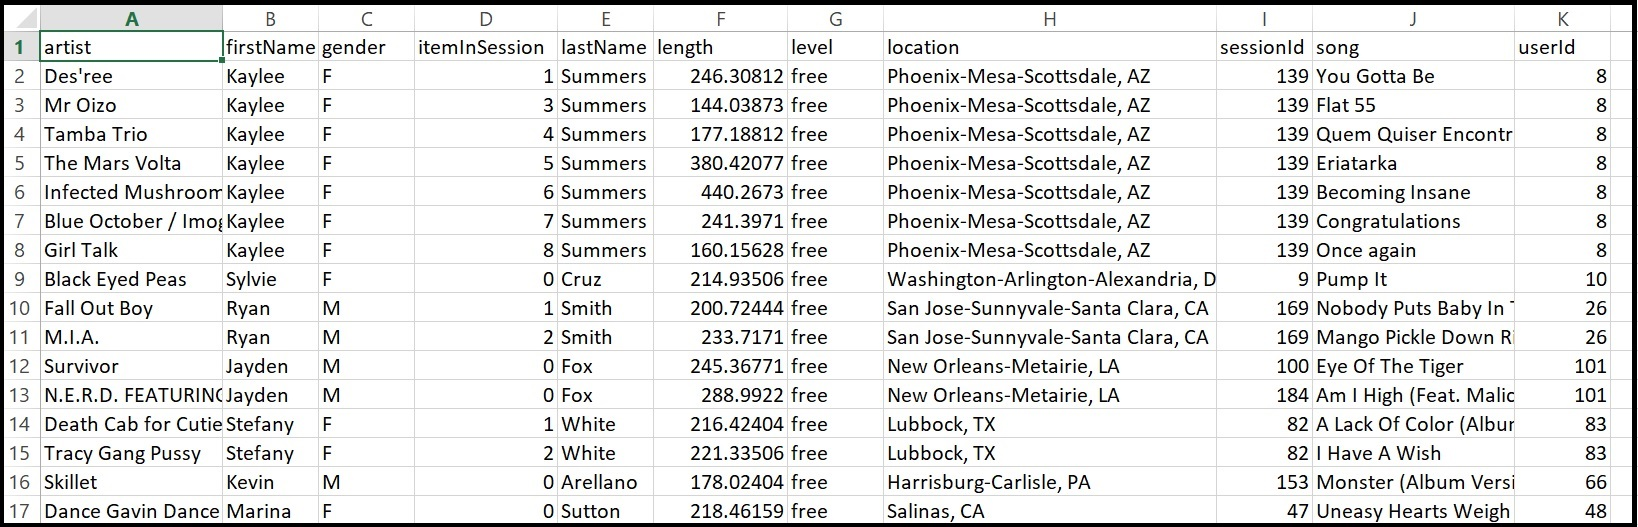

#### Creating a Cluster

In [6]:
# Making a connection to a Cassandra instance on our local machine (127.0.0.1)
try:
    cluster = Cluster(['127.0.0.1'])
    session = cluster.connect()
    print("Connection Established !!")
except Exception as e:
    print(f"Connection Failed !! Error : {e}")

Connection Established !!


##### Creating Keyspace

In [7]:
# Creating Keyspace    
keyspace_query = """CREATE KEYSPACE IF NOT EXISTS songsdb 
                    with REPLICATION = 
                    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }
                """
                
try:
    session.execute(keyspace_query)
except Exception as e:
    print(f"Failed to create keyspace!! Error : {e}")

#### Setting Keyspace

In [8]:
# Setting KEYSPACE to the keyspace specified above
session.set_keyspace('songsdb')

##  Creating tables to run the following queries (Remember, with Apache Cassandra we model the database tables on the queries we want to run)

### Below are the queries following which we will build out data model
### 1. Give the artist, song title and song's length in the music app history that was heard during sessionId = 338, and itemInSession = 4
### 2. Give only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182
### 3. Give every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'

### Query 1
### For query 1, we need a way to run query on sessionId and itemInSession. So, our primary key must have these columns. We can partition the data on sessionId.
### Our Select query : SELECT artist, song, length FROM session_item where sessionId = 338 and itemInSession = 4
### Our Primary key will be (sessionId, itemInSession), where sessionId is the partition key and itemInSession is the clustering column.
### Columns we included in the table :

In [9]:
# Creating table for query1 
create_query1 = """CREATE TABLE IF NOT EXISTS session_item (artist text, song text, length float, sessionId int, itemInSession int, PRIMARY KEY (sessionId, itemInSession))"""

try: 
    session.execute(create_query1)
    print("Table Created!!")
except Exception as e:
    print(f"Table creation failed!! Error : {e}")

Table Created!!


In [10]:
# Using the event file
file = 'event_datafile_new.csv'

# Reading csv file and inserting rows into cassandra tables.
with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skipping header
    for line in csvreader:
        query = "INSERT INTO session_item (artist, song, length, sessionId, itemInSession) "
        query = query + " VALUES (%s, %s, %s, %s, %s) "
        session.execute(query, (line[0], line[10], float(line[5]), int(line[8]), int(line[3])) )
        

In [11]:
# SELECT statement to verify the data was entered into the table
select_query1 = "SELECT artist, song, length FROM  session_item where sessionId = 338 and itemInSession = 4"
try:
    rows = session.execute(select_query1)
except Exception as e:
    print(e)
    
for row in rows:
    print(row)

Row(artist='Faithless', song='50', length=495.30731201171875)


### Query 2
### For query 2, we need a way to run query on sessionId and userId. Also, we need the data sorted on itemInSession. So, our primary key must have these columns. We can partition the data on a composite key (sessionId, userId).
### Our Select query : SELECT artist, song, firstName, lastName FROM user_session where sessionId = 182 and userId = 10
### Our Primary key will be ((sessionId, userId), itemInSession)), where (sessionId, userId) is the partition key and itemInSession is the clustering column.
### Also, we are using the clause - WITH CLUSTERING ORDER BY (itemInSession ASC), to sort our data based on itemInSession
### Columns we included in the table : sessionId, userId, artist, song, firstName, lastName, itemInSession

In [12]:
# Creating table for query2 
create_query2 = """CREATE TABLE IF NOT EXISTS user_session (sessionId int, userId int, artist text, song text, firstName text, lastName text, itemInSession int, PRIMARY KEY ((sessionId, userId), itemInSession)) WITH CLUSTERING ORDER BY (itemInSession ASC) """

try: 
    session.execute(create_query2)
    print("Table Created!!")
except Exception as e:
    print(f"Table creation failed!! Error : {e}")

Table Created!!


In [13]:
# Using the event file    
file = 'event_datafile_new.csv'

# Reading csv file and inserting rows into cassandra tables.
with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skipping header
    for line in csvreader:
        query = "INSERT INTO user_session (sessionId, userId, artist, song, firstName, lastName, itemInSession) "
        query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s) "
        session.execute(query, (int(line[8]), int(line[10]), line[0], line[9], line[1], line[4], int(line[3])  ) )

In [14]:
# SELECT statement to verify the data was entered into the table
select_query2 = "SELECT artist, song, firstName, lastName FROM  user_session where sessionId = 182 and userId = 10"
try:
    rows = session.execute(select_query2)
except Exception as e:
    print(e)

for row in rows:
    print(row)

Row(artist='Down To The Bone', song="Keep On Keepin' On", firstname='Sylvie', lastname='Cruz')
Row(artist='Three Drives', song='Greece 2000', firstname='Sylvie', lastname='Cruz')
Row(artist='Sebastien Tellier', song='Kilometer', firstname='Sylvie', lastname='Cruz')
Row(artist='Lonnie Gordon', song='Catch You Baby (Steve Pitron & Max Sanna Radio Edit)', firstname='Sylvie', lastname='Cruz')


### Query 3
### For query 3, we need a way to run query on song. So, our primary key must have song. Also, the query should be such that it does not contain duplicate users for a song. So we need to model data in such a way that we don't allow duplicate users for a song in our table. This can be acheived by including userId in our primary key.
### Our Select query : SELECT song, firstName, lastName FROM user_song where song = 'All Hands Against His Own'
### Our Primary key will be ((song), userId)), where song is the partition key and userId is ### the clustering column.
### Columns we included in the table : song, userId, firstName, lastName

In [15]:
# Creating table for query3
create_query3 = """CREATE TABLE IF NOT EXISTS user_song (song text, userId int, firstName text, lastName text, PRIMARY KEY ((song), userId))"""

try: 
    session.execute(create_query3)
    print("Table Created!!")
except Exception as e:
    print(f"Table creation failed!! Error : {e}")
    

Table Created!!


In [16]:
# Using the event file     
file = 'event_datafile_new.csv'

# Reading csv file and inserting rows into cassandra tables.
with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skipping header
    for line in csvreader:
        query = "INSERT INTO user_song (song, userId, firstName, lastName) "
        query = query + " VALUES (%s, %s, %s, %s) "
        session.execute(query, (  line[9], int(line[10]), line[1], line[4] )  )
        

In [17]:
# SELECT statement to verify the data was entered into the table
select_query2 = "SELECT song, firstName, lastName FROM user_song where song = 'All Hands Against His Own'"
try:
    rows = session.execute(select_query2)
except Exception as e:
    print(e)

for row in rows:
    print(row)

Row(song='All Hands Against His Own', firstname='Jacqueline', lastname='Lynch')
Row(song='All Hands Against His Own', firstname='Tegan', lastname='Levine')
Row(song='All Hands Against His Own', firstname='Sara', lastname='Johnson')


### Dropping the tables before closing out the sessions

In [18]:
session.execute("DROP TABLE IF EXISTS songsdb.session_item")
session.execute("DROP TABLE IF EXISTS songsdb.user_session")
session.execute("DROP TABLE IF EXISTS songsdb.user_song")

### Closing the session and cluster connection


In [19]:
session.shutdown()
cluster.shutdown()